# Modulation Classification

Developing AutoML Model for AWGN Channel for Modulation Classification. SNR Ratio's(in dB) of Channel are $[-15,-10,-5,0,5,10,15,20,25,30]$.

**Data Generation:**
Data is generated using MatLab's Communication Toolbox for Modulation Schemes QPSK, 16-QAM, 64-QAM for SNR Ratio's (in dB) $[-15,-10,-5,0,5,10,15,20,25,30]$ when signal is transmitted through Channels AWGN and Rayleigh Channels.

**Modulation Classification:**
We will use AutoML to creae a classifer that predicts Modulation Scheme depending on In-Phase and Quadrature-Phase Components at the Receiver's End.

## Imports

### Importing Libraries

We will be using AutoKeras for generating AutoML Models.
Source of Documentation: [https://autokeras.com/](https://autokeras.com/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import seaborn as sns
import scipy.io
import os

# AutoML Libraries
!pip3 install autokeras
import autokeras as ak

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras.models import Model

     |████████████████████████████████| 174kB 18.2MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=c45015340776390f3421eb1f7415d85ef90659e0ad512411a832c3d41b2a8607
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=42dc093ecff3d19948c15d7b0f1f0ef617f77c5370d8f1b3555eb2055c1ad0f2
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


### Importing Data

Files are uploaded in Google Drive. Notebook is connected to Google Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Modulation-Classification/Synthetic\ Datasets/AutoML

Mounted at /gdrive
/gdrive/My Drive/Modulation-Classification/Synthetic Datasets/AutoML


## Processsing Data

Importing Data for all SNR Ratio's

In [3]:
def ImportData(Path):
    ModulationSchemes = os.listdir(Path)

    Dataset = {}
    for scheme in ModulationSchemes:
        DataPath = Path + "/" + scheme
        files = os.listdir(DataPath)
        DataofScheme = {}
        for f in files:
            Data = scipy.io.loadmat(DataPath + "/" + f)
            snr = Data['snr'][0][0]
            rx = Data['rx']
            InPhase, QuadPhase = rx.real, rx.imag
            DataofScheme[snr] = np.append(InPhase, QuadPhase, axis=1)
        Dataset[scheme] = DataofScheme

    return Dataset

## Train and Validation Datasets

**Training:**
- Received Signal with SNR Ratio $30$dB is used for Training for both Channels and all Modulation Schemes.

**Validation:**
- AutoML is validated on Received Signals with SNR Ratio's (in dB) $[-15,-10,-5,0,5,10,15,20,25]$

In [4]:
def ImportDatasets(Channel,L=None):
    if Channel == "AWGN":
        Path =  "../Data/" + Channel
    elif Channel == "Rayleigh":
        Path = "../Data/" + Channel + "/" + str(L)
    Data = ImportData(Path)
    
    Dataset = {}
    Dataset['Classes'] = list(Data.keys())
    OneHotClasses = np.eye(len(Dataset['Classes']))

    Classes = {}
    for i in range(len(Dataset['Classes'])):
        Classes[Dataset['Classes'][i]] = OneHotClasses[i]

    Valid_SNRs = [-15,-10,-5,0,5,10,15,20,25]

    if Channel == "AWGN":
        X_Train, y_Train = np.empty((0,2)), np.empty((0,3))
        X_Valid, y_Valid = {}, {}

        for snr in Valid_SNRs:
            X_Valid[snr] = np.empty((0,2))
            y_Valid[snr] = np.empty((0,3))


        for c in Classes.keys():
            ModData = Data[c]
            SNRs = ModData.keys()
            for snr in SNRs:
                if snr == 30:
                    X = ModData[snr]
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Train = np.append(X_Train,X,axis=0)
                    y_Train = np.append(y_Train,y,axis=0)
                else:
                    X = ModData[snr]
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Valid[snr] = np.append(X_Valid[snr], X, axis=0)
                    y_Valid[snr] = np.append(y_Valid[snr], y, axis=0)

    elif Channel == "Rayleigh":
        X_Train, y_Train = np.empty((0,100,2)), np.empty((0,3))
        X_Valid, y_Valid = {}, {}
        for snr in Valid_SNRs:
            X_Valid[snr] = np.empty((0,100,2))
            y_Valid[snr] = np.empty((0,3))

        for c in Classes.keys():
            ModData = Data[c]
            SNRs = ModData.keys()
            for snr in SNRs:
                if snr == 30:
                    X = ModData[snr]
                    X = X.reshape(-1,100,2)
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Train = np.append(X_Train,X,axis=0)
                    y_Train = np.append(y_Train,y,axis=0)
                else:
                    X = ModData[snr]
                    X = X.reshape(-1,100,2)
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Valid[snr] = np.append(X_Valid[snr], X, axis=0)
                    y_Valid[snr] = np.append(y_Valid[snr], y, axis=0)

    return X_Train, y_Train, X_Valid, y_Valid

## Evaluating Data

In [5]:
def EvaluateData(Model, X_Train, y_Train, X_Valid, y_Valid, SavePath, ValidBatchSize=32):
    Valid_SNR = np.array([-15,-10,-5,0,5,10,15,20,25,30])
    Accuracy = []

    print ("Evaluating Model")
    for snr in Valid_SNR:
        if snr == 30:
            Loss, Acc = Model.evaluate(X_Train, y_Train)
        else:
            Loss, Acc = Model.evaluate(X_Valid[snr], y_Valid[snr], batch_size=ValidBatchSize)
        print ("SNR:", snr, "Accuracy:", Acc)
        Accuracy.append(Acc)

    Accuracy = np.array(Accuracy)

    plt.figure(figsize=(10,10))
    plt.plot(Valid_SNR,Accuracy, color='blue')
    plt.scatter(Valid_SNR,Accuracy, color='red')
    plt.title("Accuracy vs SNR")
    plt.xlabel("SNR")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.savefig(SavePath)
    plt.show()

## AutoML Model for AWGN Channel using Structured Data Classifer

For AWGN Channel, Input Dimensions is $(2,)$

#### AWGN Data

In [6]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('AWGN')

#### Creating a Classifier

In [7]:
AWGNClassifier = ak.StructuredDataClassifier(
    overwrite=True,
    max_trials=3,
    loss='categorical_crossentropy',
    num_classes=3)

AWGNClassifier.fit(X_Train, y_Train, epochs=15, batch_size=64, validation_split=0.1)

Trial 3 Complete [00h 00m 15s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 00m 50s
INFO:tensorflow:Oracle triggered exit
Epoch 1/15
469/469 [==============================] - 1s 2ms/step - loss: 0.8087 - accuracy: 0.8715
Epoch 2/15
469/469 [==============================] - 1s 2ms/step - loss: 1.0052 - accuracy: 0.5790
Epoch 3/15
469/469 [==============================] - 1s 2ms/step - loss: 0.8737 - accuracy: 0.6862
Epoch 4/15
469/469 [==============================] - 1s 2ms/step - loss: 0.6782 - accuracy: 0.7254
Epoch 5/15
469/469 [==============================] - 1s 2ms/step - loss: 0.6277 - accuracy: 0.7286
Epoch 6/15
469/469 [==============================] - 1s 2ms/step - loss: 0.6036 - accuracy: 0.7375
Epoch 7/15
469/469 [==============================] - 1s 2ms/step - loss: 0.5868 - accuracy: 0.7413
Epoch 8/15
469/469 [==============================] - 1s 2ms/step - loss: 0.5750 - accuracy: 0.7439
Epoch 9/15
469/469 [==============================

#### Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 2)                 0         
_________________________________________________________________
normalization (Normalization (None, 2)                 5         
_________________________________________________________________
dense (Dense)                (None, 32)                96        
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

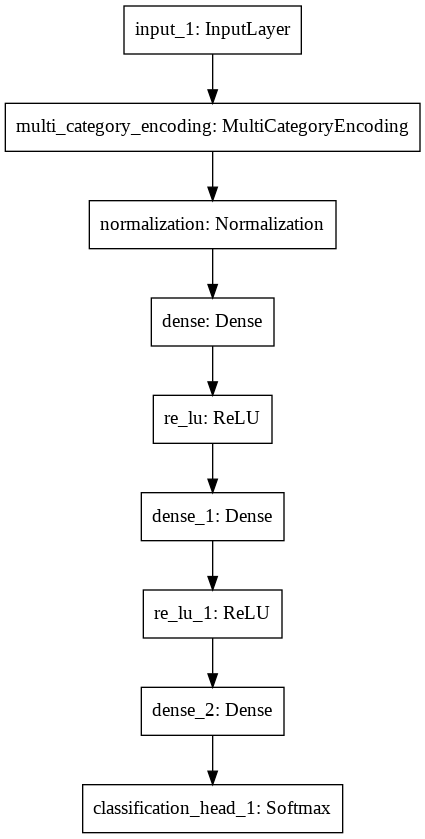

In [8]:
AWGN_Model = AWGNClassifier.export_model()
AWGN_Model.summary()
tf.keras.utils.plot_model(AWGN_Model, to_file='../Models/AWGN_Model_MLP.png', show_shapes=False,show_layer_names=True)

### Training and Evaluating Model

#### Training the Model

In [9]:
AWGN_Model.fit(X_Train, y_Train, epochs=100, batch_size=512, validation_split=0.1,shuffle=True)

Epoch 1/100
53/53 [==============================] - 1s 6ms/step - loss: 1.3788 - accuracy: 0.3844 - val_loss: 0.3204 - val_accuracy: 0.9097
Epoch 2/100
53/53 [==============================] - 0s 3ms/step - loss: 0.4776 - accuracy: 0.8617 - val_loss: 0.6052 - val_accuracy: 0.7413
Epoch 3/100
53/53 [==============================] - 0s 3ms/step - loss: 0.4137 - accuracy: 0.8500 - val_loss: 0.6182 - val_accuracy: 0.7413
Epoch 4/100
53/53 [==============================] - 0s 3ms/step - loss: 0.4020 - accuracy: 0.8463 - val_loss: 0.6135 - val_accuracy: 0.7413
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.3925 - accuracy: 0.8481 - val_loss: 0.6136 - val_accuracy: 0.7413
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 0.3825 - accuracy: 0.8529 - val_loss: 0.6129 - val_accuracy: 0.7413
Epoch 7/100
53/53 [==============================] - 0s 3ms/step - loss: 0.3721 - accuracy: 0.8607 - val_loss: 0.6142 - val_accuracy: 0.7413
Epoch 8/100
5

#### Evaluate the Model

Evaluating Model
938/938 [==============================] - 2s 2ms/step - loss: 63.7366 - accuracy: 0.3568
SNR: -15 Accuracy: 0.3568333387374878
938/938 [==============================] - 2s 2ms/step - loss: 29.2186 - accuracy: 0.3986
SNR: -10 Accuracy: 0.39856666326522827
938/938 [==============================] - 2s 2ms/step - loss: 12.5827 - accuracy: 0.4875
SNR: -5 Accuracy: 0.4874666631221771
938/938 [==============================] - 2s 2ms/step - loss: 5.8808 - accuracy: 0.5802
SNR: 0 Accuracy: 0.5802333354949951
938/938 [==============================] - 2s 2ms/step - loss: 3.0404 - accuracy: 0.6546
SNR: 5 Accuracy: 0.6545666456222534
938/938 [==============================] - 2s 2ms/step - loss: 1.6403 - accuracy: 0.7307
SNR: 10 Accuracy: 0.7306666374206543
938/938 [==============================] - 2s 2ms/step - loss: 0.7822 - accuracy: 0.8128
SNR: 15 Accuracy: 0.8127666711807251
938/938 [==============================] - 2s 2ms/step - loss: 0.3688 - accuracy: 0.8852
SNR: 20 

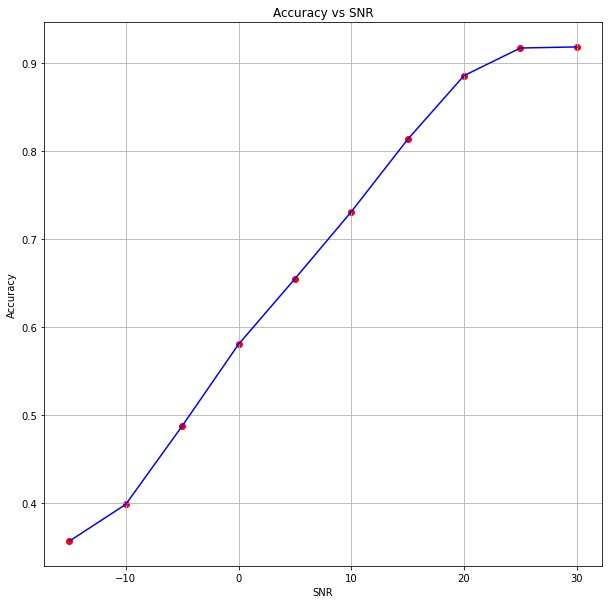

In [10]:
EvaluateData(AWGN_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/AWGN_Accuracy_MLP.jpg")

#### Save Model

In [11]:
AWGN_Model.save("../Models/AWGN_MLP.h5")

## AutoML Model for AWGN Channel using ImageClassifier

For AWGN Channel, Input Dimensions is $(100,2)$

#### AWGN Data

In [12]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('AWGN')

X_Train = X_Train.reshape(-1,100,2)
y_Train = y_Train[::100]
for snr in [-15,-10,-5,0,5,10,15,20,25]:
    X_Valid[snr] = X_Valid[snr].reshape(-1,100,2)
    y_Valid[snr] = y_Valid[snr][::100]

#### Creating a Classifier

In [13]:
AWGNClassifier = ak.ImageClassifier(
    overwrite=True,
    max_trials=1,
    loss='categorical_crossentropy',
    num_classes=3)

AWGNClassifier.fit(X_Train, y_Train, epochs=15, batch_size=64, validation_split=0.1)

Trial 1 Complete [00h 00m 32s]
val_loss: 0.5112453103065491

Best val_loss So Far: 0.5112453103065491
Total elapsed time: 00h 00m 32s
INFO:tensorflow:Oracle triggered exit
Epoch 1/15
5/5 [==============================] - 1s 37ms/step - loss: 1.3426 - accuracy: 0.3002
Epoch 2/15
5/5 [==============================] - 0s 4ms/step - loss: 1.0282 - accuracy: 0.4662
Epoch 3/15
5/5 [==============================] - 0s 4ms/step - loss: 1.0580 - accuracy: 0.1554
Epoch 4/15
5/5 [==============================] - 0s 4ms/step - loss: 1.1040 - accuracy: 0.1476
Epoch 5/15
5/5 [==============================] - 0s 4ms/step - loss: 1.1165 - accuracy: 0.1476
Epoch 6/15
5/5 [==============================] - 0s 4ms/step - loss: 1.0993 - accuracy: 0.1476
Epoch 7/15
5/5 [==============================] - 0s 4ms/step - loss: 1.0604 - accuracy: 0.1476
Epoch 8/15
5/5 [==============================] - 0s 5ms/step - loss: 1.0283 - accuracy: 0.1476
Epoch 9/15
5/5 [==============================] - 0s 4ms/st

#### Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 100, 2, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 100, 2, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 2, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 2, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 1, 64)         0     

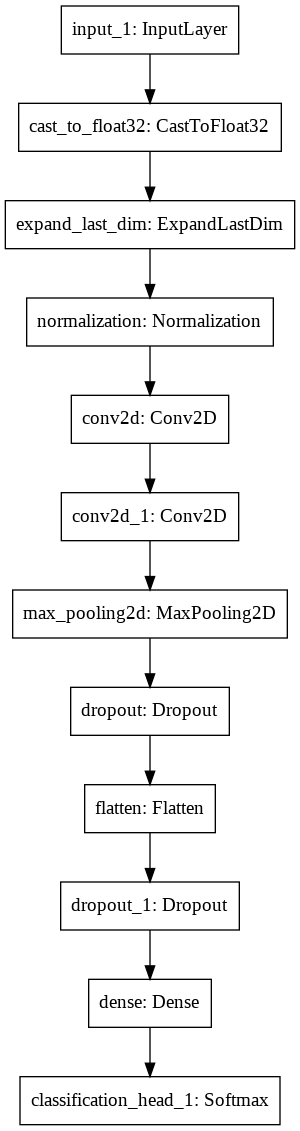

In [14]:
AWGN_Model = AWGNClassifier.export_model()
AWGN_Model.summary()
tf.keras.utils.plot_model(AWGN_Model, to_file='../Models/AWGN_Model_CNN.png', show_shapes=False,show_layer_names=True)

### Training and Evaluating Model

#### Training the Model

In [15]:
AWGN_Model.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.1,shuffle=True)

Epoch 1/25
17/17 [==============================] - 1s 22ms/step - loss: 0.7867 - accuracy: 0.6556 - val_loss: 0.4966 - val_accuracy: 0.9667
Epoch 2/25
17/17 [==============================] - 0s 5ms/step - loss: 0.6957 - accuracy: 0.8630 - val_loss: 0.1840 - val_accuracy: 1.0000
Epoch 3/25
17/17 [==============================] - 0s 5ms/step - loss: 0.5295 - accuracy: 0.9704 - val_loss: 0.3163 - val_accuracy: 1.0000
Epoch 4/25
17/17 [==============================] - 0s 5ms/step - loss: 0.2971 - accuracy: 0.9963 - val_loss: 0.1403 - val_accuracy: 1.0000
Epoch 5/25
17/17 [==============================] - 0s 5ms/step - loss: 0.1091 - accuracy: 0.9963 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 6/25
17/17 [==============================] - 0s 4ms/step - loss: 0.0431 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 7/25
17/17 [==============================] - 0s 5ms/step - loss: 0.0265 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 8/25
17/17 [=

#### Evaluate the Model

Evaluating Model
10/10 [==============================] - 0s 9ms/step - loss: 39.3975 - accuracy: 0.3333
SNR: -15 Accuracy: 0.3333333432674408
10/10 [==============================] - 0s 2ms/step - loss: 13.4879 - accuracy: 0.3333
SNR: -10 Accuracy: 0.3333333432674408
10/10 [==============================] - 0s 2ms/step - loss: 2.6556 - accuracy: 0.6667
SNR: -5 Accuracy: 0.6666666865348816
10/10 [==============================] - 0s 3ms/step - loss: 0.0963 - accuracy: 0.9700
SNR: 0 Accuracy: 0.9700000286102295
10/10 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 1.0000
SNR: 5 Accuracy: 1.0
10/10 [==============================] - 0s 2ms/step - loss: 4.4151e-04 - accuracy: 1.0000
SNR: 10 Accuracy: 1.0
10/10 [==============================] - 0s 2ms/step - loss: 4.1756e-04 - accuracy: 1.0000
SNR: 15 Accuracy: 1.0
10/10 [==============================] - 0s 2ms/step - loss: 4.1925e-04 - accuracy: 1.0000
SNR: 20 Accuracy: 1.0
10/10 [==============================

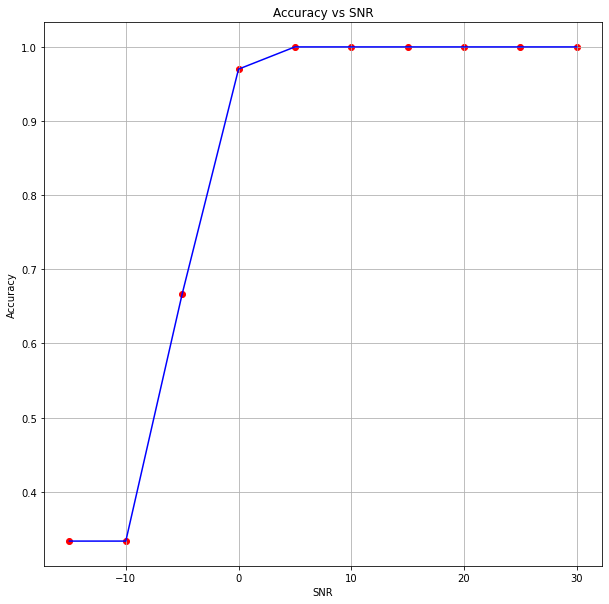

In [16]:
EvaluateData(AWGN_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/AWGN_Accuracy_CNN.jpg")

#### Save Model

In [17]:
AWGN_Model.save("../Models/AWGN_CNN.h5")

## AutoML Model for Rayleigh Channel of Channel-Length = 2

For Rayleigh Channel, Input Dimensions is (100,2)

#### Rayleigh Data

In [18]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=2)

#### Creating a CNN Classifier

In [19]:
RayleighClassifier = ak.ImageClassifier(
    overwrite=True,
    max_trials=1,
    loss='categorical_crossentropy',
    num_classes=3)

RayleighClassifier.fit(X_Train, y_Train, epochs=5, batch_size=16, validation_split=0.1)

Trial 1 Complete [00h 00m 15s]
val_loss: 6.784993729525013e-06

Best val_loss So Far: 6.784993729525013e-06
Total elapsed time: 00h 00m 15s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3222 - accuracy: 0.9769
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 1.0731 - accuracy: 0.2393
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.6133 - accuracy: 0.7917
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1568 - accuracy: 0.9639
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1299 - accuracy: 0.9711
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


#### CNN Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 100, 2, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 100, 2, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 2, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 2, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 1, 64)         0     

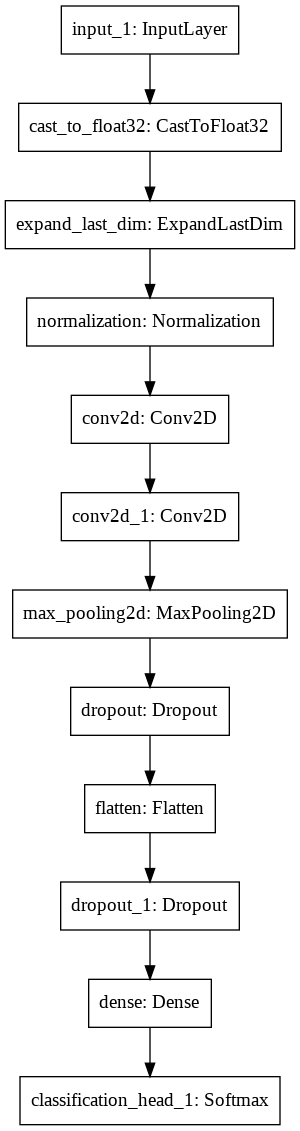

In [20]:
Rayleigh_Model = RayleighClassifier.export_model()
Rayleigh_Model.summary()
tf.keras.utils.plot_model(Rayleigh_Model, to_file='../Models/Rayleigh_Model_L=2.png', show_shapes=False,show_layer_names=True)

### Training and Evaluating CNN Model

#### Training the CNN Model

In [21]:
Rayleigh_Model.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.25,shuffle=True)

Epoch 1/25
704/704 [==============================] - 3s 4ms/step - loss: 0.1715 - accuracy: 0.9709 - val_loss: 3.3183e-05 - val_accuracy: 1.0000
Epoch 2/25
704/704 [==============================] - 3s 4ms/step - loss: 1.7137e-04 - accuracy: 1.0000 - val_loss: 6.3034e-06 - val_accuracy: 1.0000
Epoch 3/25
704/704 [==============================] - 3s 4ms/step - loss: 4.6553e-05 - accuracy: 1.0000 - val_loss: 7.3893e-06 - val_accuracy: 1.0000
Epoch 4/25
704/704 [==============================] - 2s 4ms/step - loss: 2.1378e-05 - accuracy: 1.0000 - val_loss: 2.7340e-06 - val_accuracy: 1.0000
Epoch 5/25
704/704 [==============================] - 2s 4ms/step - loss: 1.1663e-05 - accuracy: 1.0000 - val_loss: 2.0180e-06 - val_accuracy: 1.0000
Epoch 6/25
704/704 [==============================] - 3s 4ms/step - loss: 6.1985e-06 - accuracy: 1.0000 - val_loss: 1.0446e-06 - val_accuracy: 1.0000
Epoch 7/25
704/704 [==============================] - 3s 4ms/step - loss: 4.3638e-06 - accuracy: 1.0000 

#### Evaluate the CNN Model

Evaluating Model
469/469 [==============================] - 1s 2ms/step - loss: 22.6250 - accuracy: 0.4774
SNR: -15 Accuracy: 0.477400004863739
469/469 [==============================] - 1s 2ms/step - loss: 6.1044 - accuracy: 0.6165
SNR: -10 Accuracy: 0.6165333390235901
469/469 [==============================] - 1s 2ms/step - loss: 1.1968 - accuracy: 0.9251
SNR: -5 Accuracy: 0.9250666499137878
469/469 [==============================] - 1s 2ms/step - loss: 0.0246 - accuracy: 0.9955
SNR: 0 Accuracy: 0.9955333471298218
469/469 [==============================] - 1s 2ms/step - loss: 7.7928e-06 - accuracy: 1.0000
SNR: 5 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 1.2159e-09 - accuracy: 1.0000
SNR: 10 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 1.7484e-10 - accuracy: 1.0000
SNR: 15 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 3.2584e-10 - accuracy: 1.0000
SNR: 20 Accuracy: 1.0
469/469 [==========

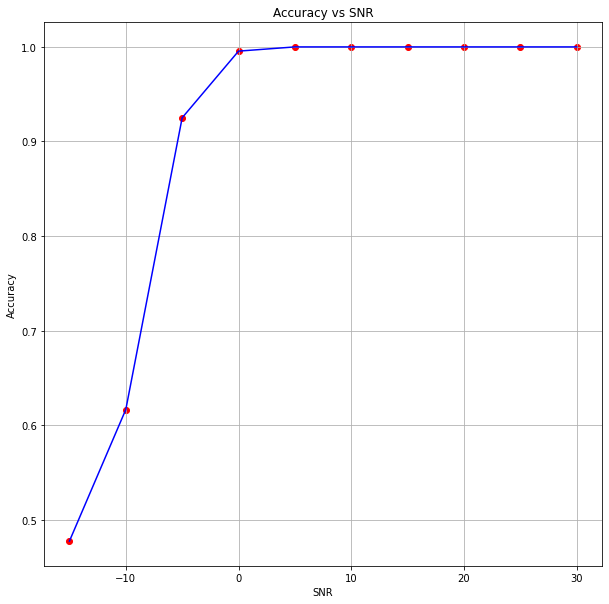

In [22]:
EvaluateData(Rayleigh_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/Rayleigh_Accuracy_L=2.jpg")

#### Save CNN Model

In [23]:
Rayleigh_Model.save("../Models/Rayleigh_L=2.h5")

## AutoML Model for Rayleigh Channel of Channel-Length = 3

For Rayleigh Channel, Input Dimensions is (100,2)

#### Rayleigh Data

In [24]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=3)

#### Creating a CNN Classifier

In [25]:
RayleighClassifier = ak.ImageClassifier(
    overwrite=True,
    max_trials=1,
    loss='categorical_crossentropy',
    num_classes=3)

RayleighClassifier.fit(X_Train, y_Train, epochs=5, batch_size=16, validation_split=0.1)

Trial 1 Complete [00h 00m 15s]
val_loss: 0.00010648679017322138

Best val_loss So Far: 0.00010648679017322138
Total elapsed time: 00h 00m 15s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1297 - accuracy: 0.9776
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 1.1200 - accuracy: 0.7581
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.7045 - accuracy: 0.8618
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.5010 - accuracy: 0.8967
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.4251 - accuracy: 0.9034
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


#### CNN Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 100, 2, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 100, 2, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 2, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 2, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 1, 64)         0     

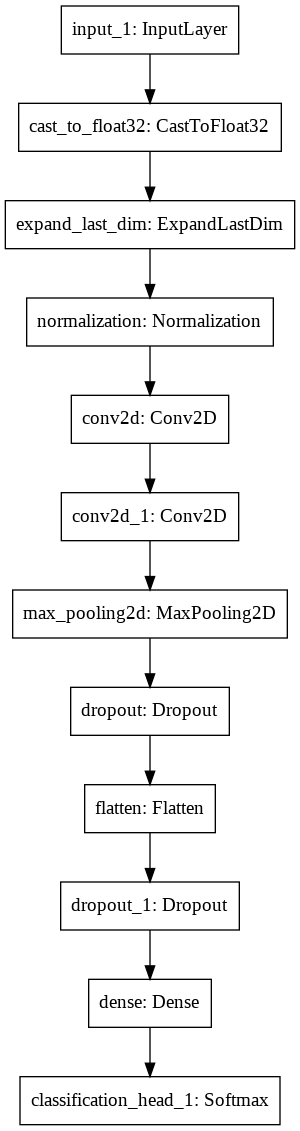

In [26]:
Rayleigh_Model = RayleighClassifier.export_model()
Rayleigh_Model.summary()
tf.keras.utils.plot_model(Rayleigh_Model, to_file='../Models/Rayleigh_Model_L=3.png', show_shapes=False,show_layer_names=True)

### Training and Evaluating CNN Model

#### Training the CNN Model

In [27]:
Rayleigh_Model.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.25,shuffle=True)

Epoch 1/25
704/704 [==============================] - 3s 4ms/step - loss: 0.2860 - accuracy: 0.9173 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 2/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0156 - accuracy: 0.9953 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 3/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0113 - accuracy: 0.9951 - val_loss: 4.9989e-04 - val_accuracy: 1.0000
Epoch 4/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0092 - accuracy: 0.9970 - val_loss: 6.4960e-04 - val_accuracy: 1.0000
Epoch 5/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0066 - accuracy: 0.9978 - val_loss: 4.4471e-04 - val_accuracy: 1.0000
Epoch 6/25
704/704 [==============================] - 2s 4ms/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 1.1587e-04 - val_accuracy: 1.0000
Epoch 7/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 1.4888e-04 - val_acc

#### Evaluate the CNN Model

Evaluating Model
469/469 [==============================] - 1s 2ms/step - loss: 369.1025 - accuracy: 0.3333
SNR: -15 Accuracy: 0.3333333432674408
469/469 [==============================] - 1s 2ms/step - loss: 161.8237 - accuracy: 0.3333
SNR: -10 Accuracy: 0.3333333432674408
469/469 [==============================] - 1s 2ms/step - loss: 60.6878 - accuracy: 0.3333
SNR: -5 Accuracy: 0.3333333432674408
469/469 [==============================] - 1s 2ms/step - loss: 17.7624 - accuracy: 0.5837
SNR: 0 Accuracy: 0.583733320236206
469/469 [==============================] - 1s 2ms/step - loss: 2.9278 - accuracy: 0.7174
SNR: 5 Accuracy: 0.7174000144004822
469/469 [==============================] - 1s 2ms/step - loss: 0.0613 - accuracy: 0.9804
SNR: 10 Accuracy: 0.980400025844574
469/469 [==============================] - 1s 2ms/step - loss: 7.7614e-04 - accuracy: 0.9996
SNR: 15 Accuracy: 0.9995999932289124
469/469 [==============================] - 1s 2ms/step - loss: 4.0798e-05 - accuracy: 1.0000


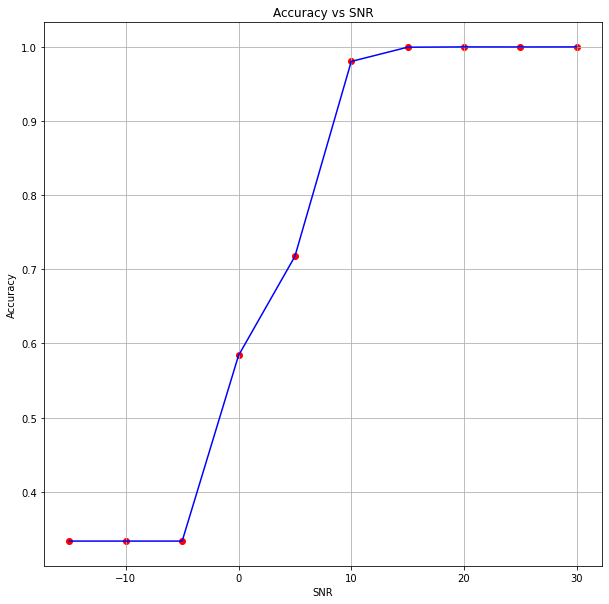

In [28]:
EvaluateData(Rayleigh_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/Rayleigh_Accuracy_L=3.jpg")

#### Save CNN Model

In [29]:
Rayleigh_Model.save("../Models/Rayleigh_L=3.h5")

## CNN Model for Rayleigh Data

This part of the code is written to verify the results with CNN.

In [30]:
def CreateCNNModel():
    tf.keras.backend.clear_session()
    In = Input(shape=(100,2,1))
    x = Conv2D(filters=64,kernel_size=(3,1),activation='relu')(In)
    x = Conv2D(filters=16,kernel_size=(3,2),activation='relu')(x)
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x)
    Ou = Dense(3,activation='softmax')(x)

    model = Model(In,Ou)
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["acc"])

    return model

### Rayleigh Fading of Channel Length = 2

Data Generation

In [31]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=2)
X_Train = np.expand_dims(X_Train,axis=-1)
for snr in [-15,-10,-5,0,5,10,15,20,25]:
    X_Valid[snr] = np.expand_dims(X_Valid[snr],axis=-1)

Model Creation

In [32]:
CNNModel2 = CreateCNNModel()
CNNModel2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 2, 64)         256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 1, 16)         6160      
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 203,539
Trainable params: 203,539
Non-trainable params: 0
_______________________________________________________

Training

In [33]:
CNNModel2.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.25,shuffle=True)

Epoch 1/25
704/704 [==============================] - 3s 4ms/step - loss: 0.1677 - acc: 0.9169 - val_loss: 3.1641e-04 - val_acc: 1.0000
Epoch 2/25
704/704 [==============================] - 2s 3ms/step - loss: 5.6299e-05 - acc: 1.0000 - val_loss: 3.5442e-05 - val_acc: 1.0000
Epoch 3/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0065 - acc: 0.9987 - val_loss: 1.0369e-04 - val_acc: 1.0000
Epoch 4/25
704/704 [==============================] - 3s 4ms/step - loss: 7.4525e-06 - acc: 1.0000 - val_loss: 4.3075e-05 - val_acc: 1.0000
Epoch 5/25
704/704 [==============================] - 3s 4ms/step - loss: 2.5953e-06 - acc: 1.0000 - val_loss: 1.3419e-05 - val_acc: 1.0000
Epoch 6/25
704/704 [==============================] - 3s 4ms/step - loss: 1.3430e-06 - acc: 1.0000 - val_loss: 6.7492e-06 - val_acc: 1.0000
Epoch 7/25
704/704 [==============================] - 3s 4ms/step - loss: 6.3543e-07 - acc: 1.0000 - val_loss: 3.5983e-06 - val_acc: 1.0000
Epoch 8/25
704/704 [========

Evaluating

Evaluating Model
469/469 [==============================] - 1s 2ms/step - loss: 52.4159 - acc: 0.3339
SNR: -15 Accuracy: 0.3338666558265686
469/469 [==============================] - 1s 2ms/step - loss: 24.0888 - acc: 0.3458
SNR: -10 Accuracy: 0.3458000123500824
469/469 [==============================] - 1s 2ms/step - loss: 7.1186 - acc: 0.7095
SNR: -5 Accuracy: 0.7094666957855225
469/469 [==============================] - 1s 2ms/step - loss: 0.4206 - acc: 0.9385
SNR: 0 Accuracy: 0.9384666681289673
469/469 [==============================] - 1s 2ms/step - loss: 0.0020 - acc: 0.9994
SNR: 5 Accuracy: 0.9994000196456909
469/469 [==============================] - 1s 2ms/step - loss: 1.2840e-05 - acc: 1.0000
SNR: 10 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 1.2144e-07 - acc: 1.0000
SNR: 15 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 5.2114e-08 - acc: 1.0000
SNR: 20 Accuracy: 1.0
469/469 [==============================] - 1s 

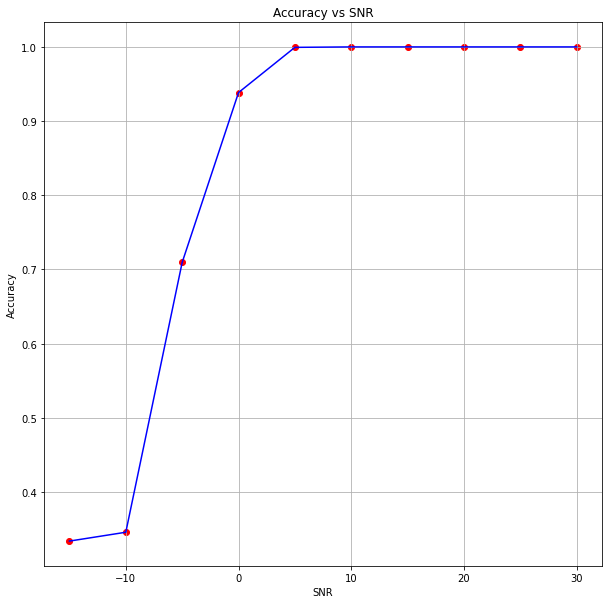

In [34]:
EvaluateData(CNNModel2, X_Train, y_Train, X_Valid, y_Valid, "../Results/CNN_Rayleigh_Accuracy_L=2.jpg")

### Rayleigh Fading of Channel Length = 3

Data Generation

In [35]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=3)
X_Train = np.expand_dims(X_Train,axis=-1)
for snr in [-15,-10,-5,0,5,10,15,20,25]:
    X_Valid[snr] = np.expand_dims(X_Valid[snr],axis=-1)

Model Creation

In [36]:
CNNModel3 = CreateCNNModel()
CNNModel3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 2, 64)         256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 1, 16)         6160      
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 203,539
Trainable params: 203,539
Non-trainable params: 0
_______________________________________________________

Training

In [37]:
CNNModel3.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.25,shuffle=True)

Epoch 1/25
704/704 [==============================] - 3s 4ms/step - loss: 0.3024 - acc: 0.8500 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 2/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0138 - acc: 0.9954 - val_loss: 5.8065e-04 - val_acc: 1.0000
Epoch 3/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0147 - acc: 0.9948 - val_loss: 0.0038 - val_acc: 0.9997
Epoch 4/25
704/704 [==============================] - 2s 3ms/step - loss: 0.0053 - acc: 0.9980 - val_loss: 1.2580e-04 - val_acc: 1.0000
Epoch 5/25
704/704 [==============================] - 2s 3ms/step - loss: 0.0013 - acc: 0.9991 - val_loss: 4.4242e-04 - val_acc: 0.9997
Epoch 6/25
704/704 [==============================] - 3s 4ms/step - loss: 5.5511e-05 - acc: 1.0000 - val_loss: 1.5056e-04 - val_acc: 1.0000
Epoch 7/25
704/704 [==============================] - 2s 4ms/step - loss: 2.6365e-05 - acc: 1.0000 - val_loss: 1.8099e-04 - val_acc: 1.0000
Epoch 8/25
704/704 [============================

Evaluating

Evaluating Model
469/469 [==============================] - 1s 2ms/step - loss: 98.3178 - acc: 0.3438
SNR: -15 Accuracy: 0.34380000829696655
469/469 [==============================] - 1s 2ms/step - loss: 39.1059 - acc: 0.3759
SNR: -10 Accuracy: 0.37586668133735657
469/469 [==============================] - 1s 2ms/step - loss: 8.9953 - acc: 0.5343
SNR: -5 Accuracy: 0.5342666506767273
469/469 [==============================] - 1s 2ms/step - loss: 1.4214 - acc: 0.9154
SNR: 0 Accuracy: 0.9154000282287598
469/469 [==============================] - 1s 2ms/step - loss: 0.5150 - acc: 0.9589
SNR: 5 Accuracy: 0.9588666558265686
469/469 [==============================] - 1s 2ms/step - loss: 0.0900 - acc: 0.9875
SNR: 10 Accuracy: 0.9874666929244995
469/469 [==============================] - 1s 2ms/step - loss: 0.0152 - acc: 0.9976
SNR: 15 Accuracy: 0.9976000189781189
469/469 [==============================] - 1s 2ms/step - loss: 0.0067 - acc: 0.9986
SNR: 20 Accuracy: 0.9986000061035156
469/469 [==

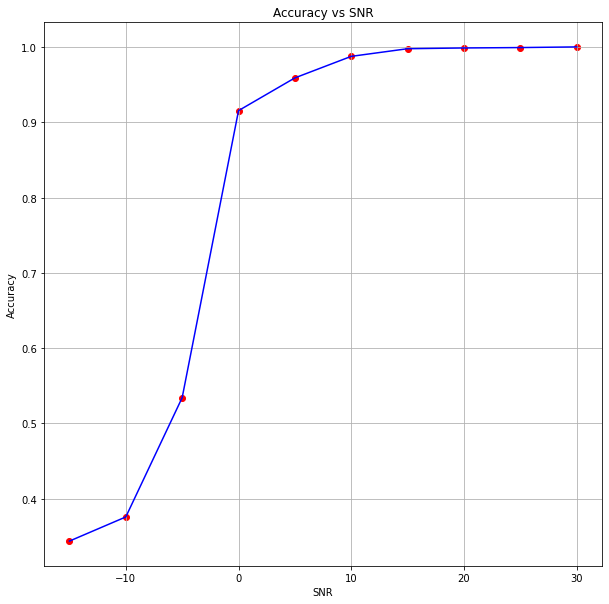

In [38]:
EvaluateData(CNNModel3, X_Train, y_Train, X_Valid, y_Valid, "../Results/CNN_Rayleigh_Accuracy_L=3.jpg")